In [1]:
!pip install comet_ml --quiet
!pip install wandb --quiet

# !pip install ultralytics ray --quiet
!pip install --upgrade ray[tune] ultralytics  --quiet
# Successfully installed ray-2.40.0 ultralytics-8.3.58 ultralytics-thop-2.0.13
# for solving AttributeError: module 'ray.train._internal.session' has no attribute '_get_session'

!pip install xmltodict --quiet

# !pip install ultralytics==8.0.196
# !pip install 'ray[tune]==2.7.1'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 MB 18.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 56.3 MB/s eta 0:00:00
  Attempting uninstall: ray
    Found existing installation: ray 2.4.0
    Uninstalling ray-2.4.0:
      Successfully uninstalled ray-2.4.0


In [2]:
from IPython.display import display, clear_output
from ipywidgets import Button, HBox, Label

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import comet_ml
import wandb

from ultralytics import YOLO
import torch


import cv2
import PIL.Image as Image

import os
import shutil
import pathlib
import sys
import yaml
import xmltodict



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
from kaggle_secrets import UserSecretsClient
comet_ml_key = "comet_ml_key"
wandb_key = "wandb_key"
comet_ml_key = UserSecretsClient().get_secret(comet_ml_key)
wandb_key = UserSecretsClient().get_secret(wandb_key)

comet_ml.init(api_key=comet_ml_key)
wandb.login(key=wandb_key)

COMET WARNING: comet_ml.init() is deprecated and will be removed soon. Please use comet_ml.login()
COMET INFO: Valid Comet API Key saved in /root/.comet.config (set COMET_CONFIG to change where it is saved).
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
num_devices=1

if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    device = [i for i in range(num_devices)]
    device_name = torch.cuda.get_device_name()
elif torch.backends.mps.is_available():
    device = "mps"
    device_name = "mps"
else:
    device = "cpu"
    device_name = "cpu"

    
print(f"Using {device_name} as the Backend.")
print(f"Number of Devices: {num_devices}")

Using Tesla P100-PCIE-16GB as the Backend.
Number of Devices: 1


In [5]:
ROOT_DIR = pathlib.Path("/kaggle/working/")


DATA_BASE_PATH = pathlib.Path(
    "/kaggle/input/stanford-dogs-dataset"
    )
IMAGES_PATH = DATA_BASE_PATH / "images/Images"
ANNOTATIONS_PATH = DATA_BASE_PATH / "annotations/Annotation"

NEW_DATA_PATH = ROOT_DIR / "data"
NEW_ANNOTATIONS_PATH = NEW_DATA_PATH / "annotations"

SLIDES_PATH = ROOT_DIR / "slides"

os.makedirs(NEW_ANNOTATIONS_PATH, exist_ok=True)
os.makedirs(SLIDES_PATH, exist_ok=True)
# set path to repo_dir
os.chdir(ROOT_DIR)

In [6]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Model & Dataset Config

In [7]:
# Dataset
TEST_TRAIN_SPLIT = 0.15
VALIDATION_TRAIN_SPLIT = 0.15
# Model Vars
IMAGE_SIZE = 640
# Training
PROJECT_NAME = "dog_breed_detection"
DEVICE = device
BATCH_SIZE = 16
EPOCHS = 35  # 60 is too much, 1 epoch in training is about 10 minutes with P100 and defaults setting, kaggle session at most is 9 hours

## Dataset

### Convert Data to model Friendly Format

In [8]:
breed_dir_name = [
        breed 
        for breed in sorted(os.listdir(IMAGES_PATH))
        if not breed.startswith(".") and os.path.isdir(IMAGES_PATH / breed)
]

len(breed_dir_name), breed_dir_name[:5]

(120,
 ['n02085620-Chihuahua',
  'n02085782-Japanese_spaniel',
  'n02085936-Maltese_dog',
  'n02086079-Pekinese',
  'n02086240-Shih-Tzu'])

In [9]:
dataset_df = pd.DataFrame(columns=["breed", "image_path", "annotation_path"])

for i, breed_dir in enumerate(breed_dir_name):
    breed_name = " ".join(breed_dir.replace("_", "-").split("-")[1:]).title()
    
    breed_images_dir_path = IMAGES_PATH / breed_dir
    breed_annotations_dir_path = ANNOTATIONS_PATH / breed_dir
    
    breed_images_name = [
            image 
            for image in sorted(os.listdir(breed_images_dir_path)) 
            if not image.startswith(".") and image.endswith((".jpg", ".jpeg", ".png"))
    ]
    breed_annotations_name = [
            image.split(".")[0]
            for image in breed_images_name
    ]
    
    breed_images_path = [
            breed_images_dir_path / image 
            for image in breed_images_name
            if os.path.isfile(breed_images_dir_path / image)
    ]
    breed_annotations_path = [
            breed_annotations_dir_path / annotation 
            for annotation in breed_annotations_name
            if os.path.isfile(breed_annotations_dir_path / annotation)
    ]
    
    dataset_df = pd.concat([dataset_df, pd.DataFrame({"breed": breed_name, "image_path": breed_images_path, "annotation_path": breed_annotations_path})])
    if i%10 ==0:
        print(f"Loading... {int(i/1.20)}% done")
    
dataset_df

Loading... 0% done
Loading... 8% done
Loading... 16% done
Loading... 25% done
Loading... 33% done
Loading... 41% done
Loading... 50% done
Loading... 58% done
Loading... 66% done
Loading... 75% done
Loading... 83% done
Loading... 91% done


,breed,image_path,annotation_path
0,Chihuahua,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...
1,Chihuahua,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...
2,Chihuahua,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...
3,Chihuahua,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...
4,Chihuahua,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...
...,...,...,...
164,African Hunting Dog,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...
165,African Hunting Dog,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...
166,African Hunting Dog,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...
167,African Hunting Dog,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...


In [10]:
dataset_df.iloc[0], dataset_df.iloc[0]['image_path'], dataset_df.iloc[0]['annotation_path']

(breed                                                      Chihuahua
 image_path         /kaggle/input/stanford-dogs-dataset/images/Ima...
 annotation_path    /kaggle/input/stanford-dogs-dataset/annotation...
 Name: 0, dtype: object,
 PosixPath('/kaggle/input/stanford-dogs-dataset/images/Images/n02085620-Chihuahua/n02085620_10074.jpg'),
 PosixPath('/kaggle/input/stanford-dogs-dataset/annotations/Annotation/n02085620-Chihuahua/n02085620_10074'))

In [11]:
def read_txt(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    return content

print(read_txt(dataset_df.iloc[0]['annotation_path']))

<annotation>
	<folder>02085620</folder>
	<filename>n02085620_10074</filename>
	<source>
		<database>ImageNet database</database>
	</source>
	<size>
		<width>333</width>
		<height>500</height>
		<depth>3</depth>
	</size>
	<segment>0</segment>
	<object>
		<name>Chihuahua</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>25</xmin>
			<ymin>10</ymin>
			<xmax>276</xmax>
			<ymax>498</ymax>
		</bndbox>
	</object>
</annotation>


In [12]:
# <annotation>
# 	<folder>02085620</folder>
# 	<filename>n02085620_10074</filename>
# 	<source>
# 		<database>ImageNet database</database>
# 	</source>
# 	<size>
# 		<width>333</width>
# 		<height>500</height>
# 		<depth>3</depth>
# 	</size>
# 	<segment>0</segment>
# 	<object>
# 		<name>Chihuahua</name>
# 		<pose>Unspecified</pose>
# 		<truncated>0</truncated>
# 		<difficult>0</difficult>
# 		<bndbox>
# 			<xmin>25</xmin>
# 			<ymin>10</ymin>
# 			<xmax>276</xmax>
# 			<ymax>498</ymax>
# 		</bndbox>
# 	</object>
# </annotation>



# <annotation>
# 	<folder>02085620</folder>
# 	<filename>n02085620_10131</filename>
# 	<source>
# 		<database>ImageNet database</database>
# 	</source>
# 	<size>
# 		<width>395</width>
# 		<height>495</height>
# 		<depth>3</depth>
# 	</size>
# 	<segment>0</segment>
# 	<object>
# 		<name>Chihuahua</name>
# 		<pose>Unspecified</pose>
# 		<truncated>0</truncated>
# 		<difficult>0</difficult>
# 		<bndbox>
# 			<xmin>49</xmin>
# 			<ymin>9</ymin>
# 			<xmax>393</xmax>
# 			<ymax>493</ymax>
# 		</bndbox>
# 	</object>
# </annotation>



In [13]:
dataset_df_path = NEW_DATA_PATH / "dataset_df.csv"
dataset_df = dataset_df.sort_values(by=["breed", "image_path"])
dataset_df.to_csv(dataset_df_path, index=False)

dataset_df = pd.read_csv(dataset_df_path)
dataset_df.head()

,breed,image_path,annotation_path
0,Affenpinscher,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...
1,Affenpinscher,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...
2,Affenpinscher,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...
3,Affenpinscher,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...
4,Affenpinscher,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...


In [14]:
import json

breeds = dataset_df["breed"].unique()
breeds_dict = {i: breed for i, breed in enumerate(breeds)}

breed_id_dict = {breed: i for i, breed in breeds_dict.items()}

breed_id_dict["Rottweiler"], breeds_dict[91]

(91, 'Rottweiler')

In [15]:
new_annotations = []
for i, annotation_path in enumerate(dataset_df["annotation_path"]):
    annotation_path = pathlib.Path(annotation_path)
    new_annotation_path = NEW_ANNOTATIONS_PATH / annotation_path.parent.name
    os.makedirs(new_annotation_path, exist_ok=True)
    annotation_name = annotation_path.name
    
    annotation_data = xmltodict.parse(annotation_path.read_text())
    image_w, image_h = (
        int(annotation_data["annotation"]["size"]["width"]), 
        int(annotation_data["annotation"]["size"]["height"])
    )
    final_data = ""
    objects = annotation_data["annotation"]["object"]
    if not isinstance(objects, list):
        objects = [objects]
        
    for obj in objects:
        breed = obj["name"]
        xmin, ymin, xmax, ymax = (
            int(obj["bndbox"]["xmin"]), 
            int(obj["bndbox"]["ymin"]), 
            int(obj["bndbox"]["xmax"]), 
            int(obj["bndbox"]["ymax"])
        )
        obj_h = ymax - ymin
        obj_w = xmax - xmin
        class_id = breed_id_dict[breed.replace("_", " ").replace("-", " ").title()]
        x, y, w, h = (
            (xmin + obj_w/2) / image_w,
            (ymin + obj_h/2) / image_h,
            (obj_w) /image_w ,
            (obj_h) / image_h
        )
            
        final_data += f"{class_id} {x} {y} {w} {h}\n"
    
    if i%2000==0:
        print(f"{i} done")
    new_annotation_path = new_annotation_path / (annotation_name+".txt")
    new_annotation_path.write_text(final_data)
    new_annotations.append(new_annotation_path)


0 done
2000 done
4000 done
6000 done
8000 done
10000 done
12000 done
14000 done
16000 done
18000 done
20000 done


In [16]:
dataset_df["new_annotation_path"] = new_annotations
dataset_df.to_csv(dataset_df_path, index=False)

dataset_df = dataset_df.sample(frac=1).reset_index(drop=True)
dataset_df

,breed,image_path,annotation_path,new_annotation_path
0,Samoyed,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...,/kaggle/working/data/annotations/n02111889-Sam...
1,Borzoi,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...,/kaggle/working/data/annotations/n02090622-bor...
2,West Highland White Terrier,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...,/kaggle/working/data/annotations/n02098286-Wes...
3,Basenji,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...,/kaggle/working/data/annotations/n02110806-bas...
4,Weimaraner,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...,/kaggle/working/data/annotations/n02092339-Wei...
...,...,...,...,...
20575,Labrador Retriever,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...,/kaggle/working/data/annotations/n02099712-Lab...
20576,Lhasa,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...,/kaggle/working/data/annotations/n02098413-Lha...
20577,Chow,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...,/kaggle/working/data/annotations/n02112137-cho...
20578,American Staffordshire Terrier,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...,/kaggle/working/data/annotations/n02093428-Ame...


In [17]:
dataset_df.iloc[0], dataset_df.iloc[0]['image_path'], dataset_df.iloc[0]['annotation_path'], dataset_df.iloc[0]['new_annotation_path']

(breed                                                            Samoyed
 image_path             /kaggle/input/stanford-dogs-dataset/images/Ima...
 annotation_path        /kaggle/input/stanford-dogs-dataset/annotation...
 new_annotation_path    /kaggle/working/data/annotations/n02111889-Sam...
 Name: 0, dtype: object,
 '/kaggle/input/stanford-dogs-dataset/images/Images/n02111889-Samoyed/n02111889_3345.jpg',
 '/kaggle/input/stanford-dogs-dataset/annotations/Annotation/n02111889-Samoyed/n02111889_3345',
 PosixPath('/kaggle/working/data/annotations/n02111889-Samoyed/n02111889_3345.txt'))

In [18]:
def read_txt(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    return content

read_txt(dataset_df.iloc[0]['new_annotation_path']), print(read_txt(dataset_df.iloc[0]['new_annotation_path']))

94 0.536 0.5746666666666667 0.924 0.7706666666666667



('94 0.536 0.5746666666666667 0.924 0.7706666666666667\n', None)

In [19]:
NEW_DATA_PATH,TEST_TRAIN_SPLIT

(PosixPath('/kaggle/working/data'), 0.15)

In [20]:
test_split = TEST_TRAIN_SPLIT

test_df = dataset_df.sample(frac=test_split)
train_df = dataset_df.drop(test_df.index)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df_path = NEW_DATA_PATH / "train_df.csv"
test_df_path = NEW_DATA_PATH / "test_df.csv"

train_df.to_csv(train_df_path, index=False)
test_df.to_csv(test_df_path, index=False)

val_split = VALIDATION_TRAIN_SPLIT
val_df = train_df.sample(frac=val_split)
train_df = train_df.drop(val_df.index)

a,b,c = len(train_df), len(val_df), len(test_df)

print(f"Train set has {a} images")
print(f"Validation set has {b} images")
print(f"Test set has {c} images")

Train set has 14869 images
Validation set has 2624 images
Test set has 3087 images


In [21]:
train_dir = NEW_DATA_PATH / "train"
val_dir = NEW_DATA_PATH / "val"
test_dir = NEW_DATA_PATH / "test"

In [22]:
try: 

    for image_path, label_path in zip(train_df["image_path"], train_df["new_annotation_path"]):
        image_path = pathlib.Path(image_path)
        label_path = pathlib.Path(label_path)
        images_dir_path = train_dir / "images"
        labels_dir_path = train_dir / "labels"
        os.makedirs(images_dir_path, exist_ok=True)
        os.makedirs(labels_dir_path, exist_ok=True)
        
        os.symlink(image_path, images_dir_path / image_path.name)
        os.symlink(label_path, labels_dir_path / label_path.name)

    for image_path, label_path in zip(val_df["image_path"], val_df["new_annotation_path"]):
        image_path = pathlib.Path(image_path)
        label_path = pathlib.Path(label_path)
        images_dir_path = val_dir / "images"
        labels_dir_path = val_dir / "labels"
        os.makedirs(images_dir_path, exist_ok=True)
        os.makedirs(labels_dir_path, exist_ok=True)
        
        os.symlink(image_path, images_dir_path / image_path.name)
        os.symlink(label_path, labels_dir_path / label_path.name)

    for image_path, label_path in zip(test_df["image_path"], test_df["new_annotation_path"]):
        image_path = pathlib.Path(image_path)
        label_path = pathlib.Path(label_path)
        images_dir_path = test_dir / "images"
        labels_dir_path = test_dir / "labels"
        os.makedirs(images_dir_path, exist_ok=True)
        os.makedirs(labels_dir_path, exist_ok=True)
        
        os.symlink(image_path, images_dir_path / image_path.name)
        os.symlink(label_path, labels_dir_path / label_path.name)

except FileExistsError:
    pass

In [23]:
breeds_dict

{0: 'Affenpinscher',
 1: 'Afghan Hound',
 2: 'African Hunting Dog',
 3: 'Airedale',
 4: 'American Staffordshire Terrier',
 5: 'Appenzeller',
 6: 'Australian Terrier',
 7: 'Basenji',
 8: 'Basset',
 9: 'Beagle',
 10: 'Bedlington Terrier',
 11: 'Bernese Mountain Dog',
 12: 'Black And Tan Coonhound',
 13: 'Blenheim Spaniel',
 14: 'Bloodhound',
 15: 'Bluetick',
 16: 'Border Collie',
 17: 'Border Terrier',
 18: 'Borzoi',
 19: 'Boston Bull',
 20: 'Bouvier Des Flandres',
 21: 'Boxer',
 22: 'Brabancon Griffon',
 23: 'Briard',
 24: 'Brittany Spaniel',
 25: 'Bull Mastiff',
 26: 'Cairn',
 27: 'Cardigan',
 28: 'Chesapeake Bay Retriever',
 29: 'Chihuahua',
 30: 'Chow',
 31: 'Clumber',
 32: 'Cocker Spaniel',
 33: 'Collie',
 34: 'Curly Coated Retriever',
 35: 'Dandie Dinmont',
 36: 'Dhole',
 37: 'Dingo',
 38: 'Doberman',
 39: 'English Foxhound',
 40: 'English Setter',
 41: 'English Springer',
 42: 'Entlebucher',
 43: 'Eskimo Dog',
 44: 'Flat Coated Retriever',
 45: 'French Bulldog',
 46: 'German Sheph

In [24]:
import yaml
dataset_details = {
    "path": str(NEW_DATA_PATH),
    "train": "train",
    "val": "val",
    "test": "test",
    
    "names": breeds_dict
}

dataset_yaml_path = ROOT_DIR / "detection/dataset.yaml"
os.makedirs(dataset_yaml_path.parent, exist_ok=True)

with open(dataset_yaml_path, "w") as f:
    yaml.dump(dataset_details, f, default_flow_style=False)
    
CLASS_NAMES = list(breeds_dict.values())
NUM_CLASSES = len(CLASS_NAMES)

In [25]:
NUM_CLASSES, CLASS_NAMES

(120,
 ['Affenpinscher',
  'Afghan Hound',
  'African Hunting Dog',
  'Airedale',
  'American Staffordshire Terrier',
  'Appenzeller',
  'Australian Terrier',
  'Basenji',
  'Basset',
  'Beagle',
  'Bedlington Terrier',
  'Bernese Mountain Dog',
  'Black And Tan Coonhound',
  'Blenheim Spaniel',
  'Bloodhound',
  'Bluetick',
  'Border Collie',
  'Border Terrier',
  'Borzoi',
  'Boston Bull',
  'Bouvier Des Flandres',
  'Boxer',
  'Brabancon Griffon',
  'Briard',
  'Brittany Spaniel',
  'Bull Mastiff',
  'Cairn',
  'Cardigan',
  'Chesapeake Bay Retriever',
  'Chihuahua',
  'Chow',
  'Clumber',
  'Cocker Spaniel',
  'Collie',
  'Curly Coated Retriever',
  'Dandie Dinmont',
  'Dhole',
  'Dingo',
  'Doberman',
  'English Foxhound',
  'English Setter',
  'English Springer',
  'Entlebucher',
  'Eskimo Dog',
  'Flat Coated Retriever',
  'French Bulldog',
  'German Shepherd',
  'German Short Haired Pointer',
  'Giant Schnauzer',
  'Golden Retriever',
  'Gordon Setter',
  'Great Dane',
  'Great

### Data Visualization

In [26]:
dataset_df.head()

,breed,image_path,annotation_path,new_annotation_path
0,Samoyed,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...,/kaggle/working/data/annotations/n02111889-Sam...
1,Borzoi,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...,/kaggle/working/data/annotations/n02090622-bor...
2,West Highland White Terrier,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...,/kaggle/working/data/annotations/n02098286-Wes...
3,Basenji,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...,/kaggle/working/data/annotations/n02110806-bas...
4,Weimaraner,/kaggle/input/stanford-dogs-dataset/images/Ima...,/kaggle/input/stanford-dogs-dataset/annotation...,/kaggle/working/data/annotations/n02092339-Wei...


#### Helper Functions

In [27]:
def load_image(image_path):
    image = Image.open(image_path)
    return np.array(image)

def render_results(
    image, 
    boxes: list[float], 
    classes: list[int],
    give_labels: bool = True,
):
    # image - single image
    # boxes - list of boxes; box = [x, y, w, h]
    # labels - list of labels; label = int
    
    cmap = plt.get_cmap("tab20b")
    colors = np.array([cmap(i%20)[:-1] for i in range(NUM_CLASSES)]) * 255
    
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    image_h, image_w, _ = image_cv.shape
    
    for box, cls in zip(boxes, classes):
        x, y, w, h = box
        x, y, w, h = (
            x * image_w,
            y * image_h,
            w * image_w,
            h * image_h
        )
        
        x1, x2 = int(x - w / 2), int(x + w / 2)
        y1, y2 = int(y - h / 2), int(y + h / 2)
        
        b_col = colors[int(cls)]
        image_cv = cv2.rectangle(image_cv, (x1, y1), (x2, y2), b_col, 2)
        cls_name = CLASS_NAMES[int(cls)]
        
        # add text
        if give_labels:
            text_size, _ = cv2.getTextSize(cls_name, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            text_position = (x1 + 1, y2 - 2)
            
            image_cv = cv2.rectangle(
                image_cv,
                (x1, y2),
                (x1 + text_size[0], y2 - text_size[1] - 4),
                b_col,
                -1,  # filled rectangle
            )
            image_cv = cv2.putText(
                image_cv, 
                cls_name, 
                text_position, 
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.6, 
                (255, 255, 255), 
                2,
                cv2.LINE_AA,
                False,
            )
        
    image = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
        
    return image


In [28]:
slide_vars = {}

def image_slider(images, slide_name=None, num_images=8):
    slide_name = slide_name or np.random.randint(0, 100000)
    if num_images > len(images) or num_images == -1:
        num_images = len(images)

    def save_as_slides(slide_name, images):
        save_path = SLIDES_PATH / f"slide_{slide_name}"

        os.makedirs(save_path, exist_ok=True)
        try:
            shutil.rmtree(save_path)
            os.makedirs(save_path)
            for image in images:
                image = Image.fromarray(image)
                image.save(save_path / f"{np.random.randint(0, 100000)}.jpg")
        except Exception as e:
            print(e)
            print("Error while saving images as slides")

    def load_slides(slide_num) -> list:
        slide_path = ROOT_DIR / f"slides/slide_{slide_num}"
        images = [str(slide_path / image) for image in os.listdir(slide_path) if image.endswith(".jpg")]
        return str(slide_path), images

    save_as_slides(slide_name, images[:num_images])
    _, images = load_slides(slide_name)

    global slide_vars
    slide_vars[slide_name] = {"image_index": 0}
    current_slide = slide_vars[slide_name]

    # Show image
    def show_image():
        clear_output(wait=True)
        display(HBox([current_slide["previous_button"], current_slide["index_label"],current_slide["next_button"],],layout={'justify_content': 'center'}))
        image_path = images[current_slide["image_index"]]
        image = plt.imread(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

    def update_label():
        current_slide["index_label"].value = f"{current_slide['image_index'] + 1}/{num_images}"

    def button_click(step):
        current_slide = slide_vars[slide_name]

        idx = current_slide["image_index"] + step
        idx = idx % num_images
        current_slide["image_index"] = idx
        update_label()
        show_image()

    previous_button = Button(description='Previous', button_style='info', layout={'width': 'auto'})
    previous_button.on_click(lambda x: button_click(-1))
    current_slide["previous_button"] = previous_button

    next_button = Button(description='Next', button_style='info', layout={'width': 'auto'})
    next_button.on_click(lambda x: button_click(1))
    current_slide["next_button"] = next_button

    index_label = Label(value=f"{current_slide['image_index'] + 1}/{num_images}")
    current_slide["index_label"] = index_label
    
    show_image()
    


In [29]:
data_sample = dataset_df.sample(8)

images, all_boxes, all_classes = [], [], []

for image_path, annotation_path in zip(data_sample["image_path"], data_sample["new_annotation_path"]):
    image = load_image(image_path)
    images.append(image)

    boxes, classes = [], []
    with open(annotation_path, "r") as f:
        data = f.readlines()
        
    for line in data:
        cls_, x, y, w, h = line.split()
        cls_, x, y, w, h = int(cls_), float(x), float(y), float(w), float(h)
        boxes.append([x, y, w, h])
        classes.append(cls_)
            
    all_boxes.append(boxes)
    all_classes.append(classes)

all_classes

[[32], [54], [41, 41], [113], [41], [47], [4], [103]]

In [30]:
len(images)

8

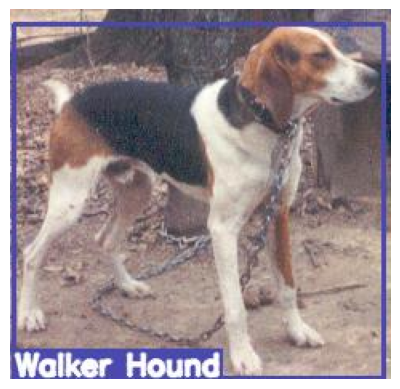

In [31]:
slide_name = 1

result_images = []

for idx in range(len(images)):
    image = images[idx]
    boxes = all_boxes[idx]
    classes = all_classes[idx]

    result_images.append(render_results(image, boxes, classes))

image_slider(result_images, slide_name=slide_name)

result_images = None

## Model

#### Basic inferance

In [32]:
!pip uninstall ultralytics ray -y
!pip install ultralytics
!pip install 'ray[tune]'

# Found existing installation: ultralytics 8.3.58
# Uninstalling ultralytics-8.3.58:
#   Successfully uninstalled ultralytics-8.3.58
# Found existing installation: ray 2.4.0
# Uninstalling ray-2.4.0:
#   Successfully uninstalled ray-2.4.0

# ray-2.40.0-cp310-cp310-manylinux2014_x86_64.whl
# Successfully installed ray-2.40.0

Found existing installation: ultralytics 8.3.58
Uninstalling ultralytics-8.3.58:
  Successfully uninstalled ultralytics-8.3.58
Found existing installation: ray 2.40.0
Uninstalling ray-2.40.0:
  Successfully uninstalled ray-2.40.0
  Using cached ultralytics-8.3.58-py3-none-any.whl (905 kB)
  Using cached ray-2.40.0-cp310-cp310-manylinux2014_x86_64.whl (66.8 MB)


In [33]:
pip list | grep ultralytics

ultralytics                            8.3.58
ultralytics-thop                       2.0.13
Note: you may need to restart the kernel to use updated packages.


In [34]:
!pip install --upgrade ray

In [ ]:
# from ultralytics.utils.callbacks.raytune import on_fit_epoch_end

EPOCHS = 35

model_name = "yolov8m"
version = "v1"
experiment_name = f"{model_name}-{version}"
# save_dir = f"runs/train/{projext_name}"
resume = False

if resume:
    pass
    # weight = f"{save_dir}/weights/last.pt"
    # model = YOLO(weight)
    # model.train(resume=True)
    
else:
    model = YOLO(model_name)
    
    # 移除 Ray Tune 回调
    # model.add_callback("on_fit_epoch_end", on_fit_epoch_end, remove=True)

    model.train(
        data=dataset_yaml_path, 
        epochs=EPOCHS, 
        imgsz=IMAGE_SIZE, 
        batch=BATCH_SIZE,
        device=DEVICE,
        project=PROJECT_NAME,
        
        name=experiment_name,
        
        exist_ok=True,
        patience = 15,
        save_period=5
        )


100%|██████████| 49.7M/49.7M [00:00<00:00, 279MB/s]


Ultralytics 8.3.58 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/detection/dataset.yaml, epochs=35, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=[0], workers=8, project=dog_breed_detection, name=yolov8m-v1, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_label

100%|██████████| 755k/755k [00:00<00:00, 42.1MB/s]
2025-01-07 09:46:59,769	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-01-07 09:47:00,058	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(

Overriding model.yaml nc=80 with nc=120

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralyti

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET WARNING: Failing to collect the installed pip packages
COMET INFO: Experiment is live on comet.com https://www.comet.com/chg0901/dog-breed-detection/ff9d9da45a53455799cfdab3a7ca4024

COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


TensorBoard: Start with 'tensorboard --logdir dog_breed_detection/yolov8m-v1', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 144MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/data/train/labels... 14867 images, 0 backgrounds, 3 corrupt: 100%|██████████| 14869/14869 [00:41<00:00, 358.38it/s]

train: WARNING ⚠️ /kaggle/working/data/train/images/n02089973_1763.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/working/data/train/images/n02089973_1763.jpg'
train: WARNING ⚠️ /kaggle/working/data/train/images/n02089973_2054.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/working/data/train/images/n02089973_2054.jpg'
train: WARNING ⚠️ /kaggle/working/data/train/images/n02106030_3948.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0278]


train: New cache created: /kaggle/working/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/data/val/labels... 2624 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2624/2624 [00:06<00:00, 378.15it/s]


val: New cache created: /kaggle/working/data/val/labels.cache
Plotting labels to dog_breed_detection/yolov8m-v1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=8.1e-05, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to dog_breed_detection/yolov8m-v1
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      8.77G     0.6691      4.064      1.258          5        640: 100%|██████████| 930/930 [09:40<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:29<00:00,  2.78it/s]


                   all       2624       2823      0.297      0.289       0.18      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/35      8.82G     0.6374      2.738      1.196          5        640: 100%|██████████| 930/930 [09:29<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.90it/s]


                   all       2624       2823      0.384      0.469      0.395      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/35      8.69G     0.6264       2.28      1.182          8        640: 100%|██████████| 930/930 [09:26<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.91it/s]


                   all       2624       2823      0.453      0.536      0.516      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/35      8.82G     0.6178      2.033      1.171          7        640: 100%|██████████| 930/930 [09:24<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.92it/s]

                   all       2624       2823      0.518      0.564      0.599      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/35      8.81G      0.607      1.839      1.159          5        640: 100%|██████████| 930/930 [09:24<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:27<00:00,  2.93it/s]

                   all       2624       2823      0.575      0.632      0.668      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/35      8.82G     0.5945      1.699       1.15          3        640: 100%|██████████| 930/930 [09:24<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.91it/s]

                   all       2624       2823      0.603      0.631      0.687      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/35       8.8G     0.5853      1.579       1.14          3        640: 100%|██████████| 930/930 [09:24<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.91it/s]

                   all       2624       2823      0.639      0.663      0.717      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/35      8.82G     0.5757      1.488      1.134          5        640: 100%|██████████| 930/930 [09:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.91it/s]

                   all       2624       2823      0.692      0.686      0.751      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/35      8.81G     0.5639      1.411      1.127          7        640: 100%|██████████| 930/930 [09:24<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.92it/s]

                   all       2624       2823      0.717      0.671       0.76      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/35      8.82G     0.5583      1.355      1.121          6        640: 100%|██████████| 930/930 [09:24<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.92it/s]

                   all       2624       2823      0.699      0.714      0.777      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/35      8.79G     0.5491      1.295      1.114          7        640: 100%|██████████| 930/930 [09:24<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.91it/s]

                   all       2624       2823      0.715      0.722      0.788      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/35      8.81G     0.5416      1.246       1.11          8        640: 100%|██████████| 930/930 [09:24<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.92it/s]

                   all       2624       2823      0.716      0.745      0.799      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/35      8.84G      0.538       1.21      1.105          7        640: 100%|██████████| 930/930 [09:24<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.92it/s]

                   all       2624       2823      0.744       0.76      0.814      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/35      8.81G     0.5316      1.165        1.1          5        640: 100%|██████████| 930/930 [09:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.91it/s]

                   all       2624       2823      0.746      0.727        0.8      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/35      8.79G     0.5275      1.132      1.098          9        640: 100%|██████████| 930/930 [09:26<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.90it/s]

                   all       2624       2823       0.77      0.731       0.82       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/35      8.82G     0.5191      1.082      1.091          4        640: 100%|██████████| 930/930 [09:26<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.92it/s]

                   all       2624       2823      0.774      0.748      0.821       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/35      8.79G     0.5144      1.049      1.087          5        640: 100%|██████████| 930/930 [09:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.92it/s]

                   all       2624       2823      0.773      0.775      0.829      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/35      8.81G     0.5132      1.027      1.087          6        640: 100%|██████████| 930/930 [09:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.91it/s]

                   all       2624       2823      0.778      0.765      0.831      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/35       8.8G     0.5049     0.9965      1.083          6        640: 100%|██████████| 930/930 [09:26<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.92it/s]

                   all       2624       2823      0.769      0.767      0.829      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/35      8.82G     0.5055     0.9698      1.082          7        640: 100%|██████████| 930/930 [09:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.89it/s]

                   all       2624       2823       0.79      0.757      0.834       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/35      8.79G     0.4953     0.9458      1.074          7        640: 100%|██████████| 930/930 [09:26<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.90it/s]

                   all       2624       2823      0.785      0.766      0.839      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/35      8.82G     0.4909     0.9193      1.072          8        640: 100%|██████████| 930/930 [09:27<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.91it/s]

                   all       2624       2823      0.804      0.768      0.846      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/35       8.8G     0.4885     0.8975      1.068          5        640: 100%|██████████| 930/930 [09:27<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.91it/s]

                   all       2624       2823       0.79      0.784      0.843      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/35      8.82G     0.4871     0.8738      1.069          3        640: 100%|██████████| 930/930 [09:26<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.91it/s]

                   all       2624       2823      0.777      0.798      0.844      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/35       8.8G     0.4783     0.8544      1.063          5        640: 100%|██████████| 930/930 [09:26<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.92it/s]

                   all       2624       2823      0.789      0.783      0.847      0.772


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/35      8.81G     0.3018     0.3927     0.9462          2        640: 100%|██████████| 930/930 [09:26<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.92it/s]

                   all       2624       2823      0.789      0.777      0.842      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/35       8.8G     0.2943     0.3537     0.9418          2        640: 100%|██████████| 930/930 [09:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.91it/s]

                   all       2624       2823      0.779      0.798      0.844      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/35      8.83G     0.2864     0.3253     0.9379          2        640: 100%|██████████| 930/930 [09:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.92it/s]

                   all       2624       2823      0.802      0.786      0.848      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/35       8.8G     0.2817     0.3086     0.9304          2        640: 100%|██████████| 930/930 [09:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.92it/s]

                   all       2624       2823      0.795      0.794      0.849      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/35      8.82G      0.276     0.2843     0.9265          2        640: 100%|██████████| 930/930 [09:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.92it/s]

                   all       2624       2823      0.809      0.782      0.849      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/35       8.8G     0.2729     0.2711     0.9232          2        640: 100%|██████████| 930/930 [09:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:27<00:00,  2.93it/s]

                   all       2624       2823      0.797      0.786      0.847      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/35      8.82G     0.2668     0.2567     0.9163          2        640: 100%|██████████| 930/930 [09:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.93it/s]

                   all       2624       2823      0.808      0.784      0.846      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/35       8.8G     0.2632     0.2447     0.9162          2        640: 100%|██████████| 930/930 [09:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:27<00:00,  2.93it/s]

                   all       2624       2823      0.796      0.796      0.849      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/35      8.82G     0.2606     0.2309     0.9127          2        640: 100%|██████████| 930/930 [09:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:28<00:00,  2.93it/s]

                   all       2624       2823      0.792      0.801      0.849      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/35       8.8G     0.2552     0.2214     0.9074          2        640: 100%|██████████| 930/930 [09:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:27<00:00,  2.94it/s]

                   all       2624       2823       0.81      0.785       0.85       0.78



35 epochs completed in 5.797 hours.
Optimizer stripped from dog_breed_detection/yolov8m-v1/weights/last.pt, 52.1MB
Optimizer stripped from dog_breed_detection/yolov8m-v1/weights/best.pt, 52.1MB

Validating dog_breed_detection/yolov8m-v1/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 218 layers, 25,909,240 parameters, 0 gradients, 79.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:29<00:00,  2.79it/s]


                   all       2624       2823       0.81      0.786       0.85       0.78
         Affenpinscher         22         22      0.929      0.773      0.946      0.885


In [ ]:
model_weight = "/kaggle/working/dog_breed_detection/yolov8m-v1/weights/last.pt"
model = model = YOLO(model_weight)
model.train(
    box=1,
    cls=5,
    dfl=8,
    resume=True
)

In [ ]:
model_weight = "/kaggle/working/dog_breed_detection/yolov8m-v1/weights/last.pt"
model = model = YOLO(model_weight)
model.train(
    box=1,
    cls=2.5,
    dfl=5,
    resume=True
)
